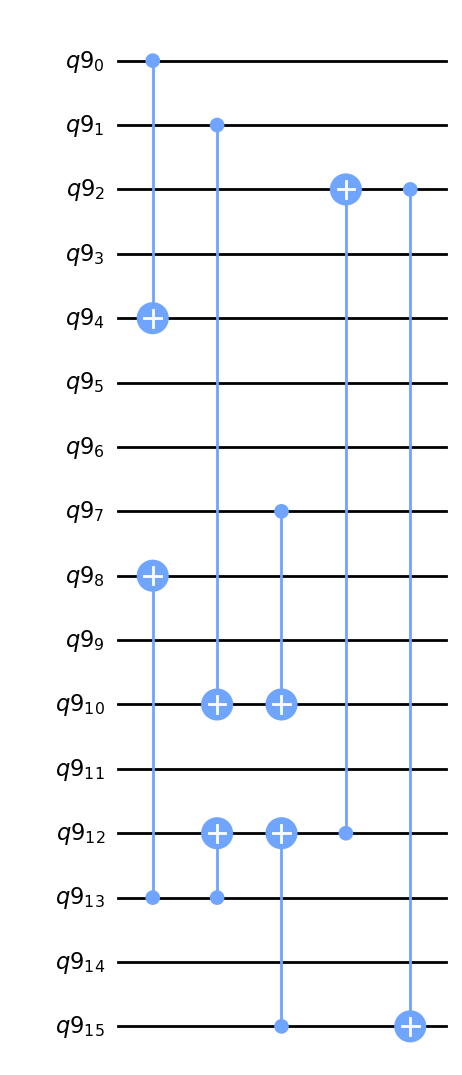

In [9]:
from qiskit import QuantumCircuit, QuantumRegister
import numpy as np

# load a dummy circuit
# generate network of random cnots
n, M = 4, 8
N = n**2
register = QuantumRegister(N)
qc = QuantumCircuit(register)

for _ in range(M):
    qc.cx(*np.random.choice(N, 2, replace=False))
qc.name = "random cx circuit"
qc.decompose().draw("mpl")

  0%|          | 0/1 [00:00<?, ?it/s]

Running random cx circuit


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

Accepted CNS subs 0
                                        
 q9_14 -> 0 ────────────────────────────
                                        
  q9_6 -> 1 ────────────────────────────
                                        
  q9_9 -> 2 ────────────────────────────
                                   ┌───┐
  q9_2 -> 3 ────────────────X──────┤ X ├
                            │ ┌───┐└─┬─┘
 q9_15 -> 4 ────────────■───X─┤ X ├──■──
                 ┌───┐┌─┴─┐   └─┬─┘     
 q9_12 -> 5 ─────┤ X ├┤ X ├─────■───────
                 └─┬─┘└───┘             
 q9_13 -> 6 ──■────■────────────────────
            ┌─┴─┐                       
  q9_8 -> 7 ┤ X ├───────────────────────
            └───┘                       
  q9_3 -> 8 ────────────────────────────
                                        
 q9_11 -> 9 ────────────────────────────
                                        
 q9_7 -> 10 ───────■────────────────────
            ┌───┐┌─┴─┐                  
q9_10 -> 11 ┤ X ├┤ X ├───────────────

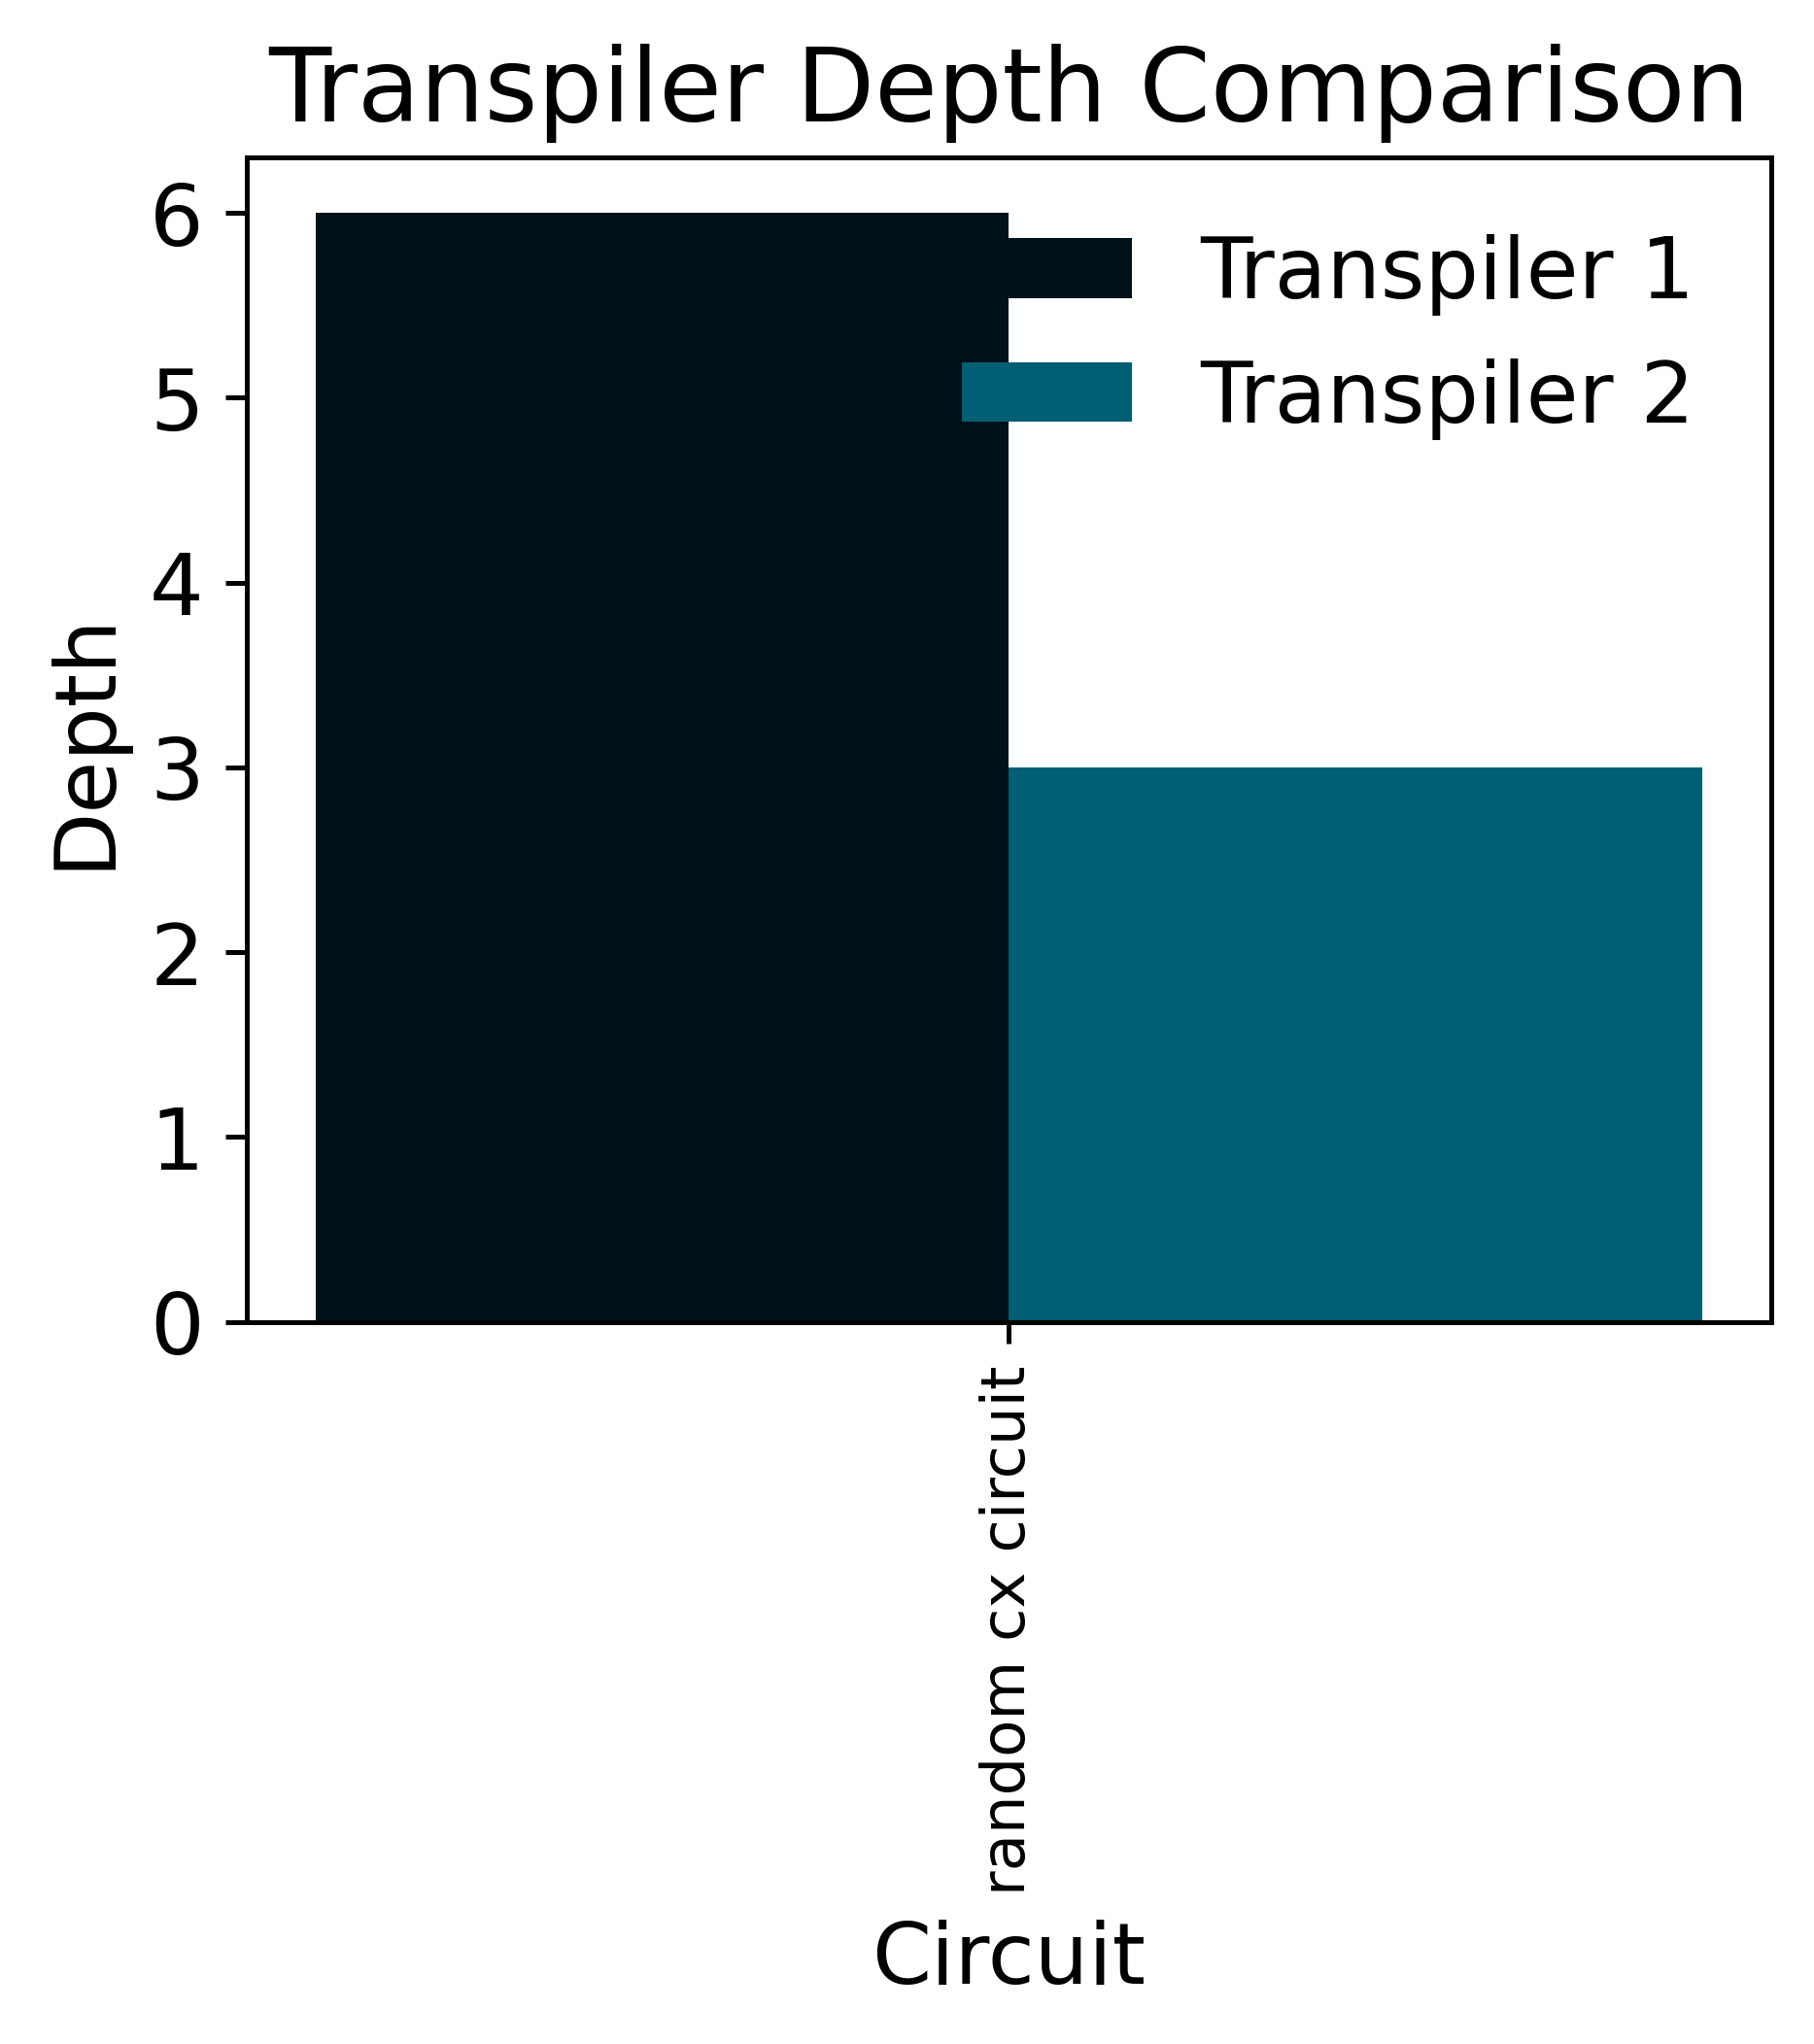

[[6, 3]]


In [11]:
from transpile_benchy.main import Benchmark
from qiskit.transpiler import CouplingMap
from virtual_swap.pass_managers import SabreCNS, Baseline, SabreQiskit

coupling = CouplingMap.from_line(N)
# t0 = Baseline(coupling)
t0 = SabreQiskit(coupling)
t1 = SabreCNS(coupling)

# b = Benchmark(t0, t1, size="small", prepath="../../../transpile_benchy")
b = Benchmark(t0, t1, circuit_list=[qc])
b.run()

# plot and save as svg
b.plot(save=True)

print(b.depth_list)